## Priyanshu Kumawat
### 211020431 - DSAI

In [1]:
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.4 MB/s eta 0:00:0000:010:01


In [2]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import AdamW
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from datasets import load_dataset
from accelerate import Accelerator
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random 
import timeit

In [3]:
RANDOM_SEED = 42
IMG_SIZE = 128
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
NUM_GENERATE_IMAGES = 9
NUM_TIMESTEPS = 1000
MIXED_PRECISION = "fp16"
GRADIENT_ACCUMULATION_STEPS = 1

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    print('yes')

yes


In [4]:
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

Downloading:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/huggan--smithsonian_butterflies_subset-7665b1021a37404c/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


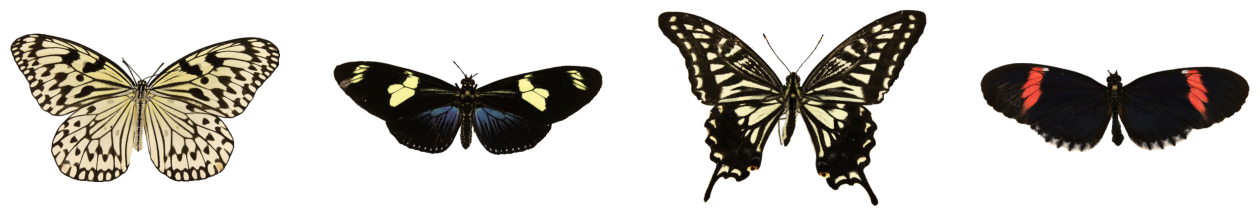

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [7]:
preprocess = transforms.Compose(
[
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [8]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

In [9]:
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
model = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D"
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    )
)
model = model.to(device)

In [11]:
sample_image = dataset[0]["images"].unsqueeze(0).to(device)
print("Input shape", sample_image.shape)
print("Output shape", model(sample_image, timestep=0).sample.shape)

Input shape torch.Size([1, 3, 128, 128])
Output shape torch.Size([1, 3, 128, 128])


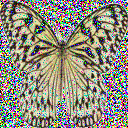

In [12]:
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TIMESTEPS)
noise = torch.randn(sample_image.shape).to(device)
timesteps = torch.LongTensor([50]).to(device)
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).cpu().numpy()[0])

In [13]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

tensor(1.1955, device='cuda:0', grad_fn=<MseLossBackward0>)


In [14]:
def sample_image_generation(model, noise_scheduler, num_generate_images, random_seed, num_timesteps):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
    
    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images
    
    fig = plt.figure()
    for i in range(1, num_generate_images+1):
        fig.add_subplot(3, 3, i)
        plt.imshow(images[i-1])
    plt.show()

100%|██████████| 63/63 [00:50<00:00,  1.25it/s]

------------------------------
Train Loss EPOCH: 1: 0.8643
Train Learning Rate EPOCH: 1: 1.2600000000000001e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

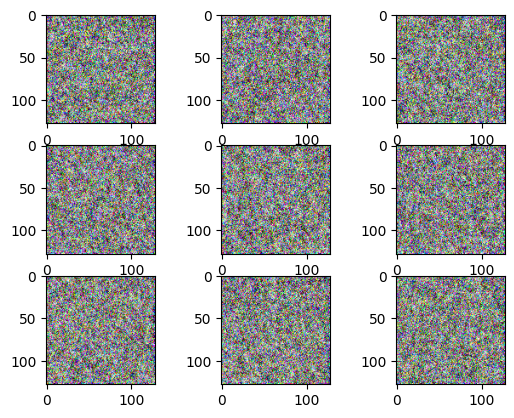

  2%|▏         | 1/50 [03:26<2:48:48, 206.71s/it]

------------------------------


  4%|▍         | 2/50 [04:16<1:31:28, 114.34s/it]

------------------------------
Train Loss EPOCH: 2: 0.1621
Train Learning Rate EPOCH: 2: 2.5200000000000003e-05
------------------------------


  6%|▌         | 3/50 [05:06<1:06:27, 84.84s/it] 

------------------------------
Train Loss EPOCH: 3: 0.0749
Train Learning Rate EPOCH: 3: 3.7800000000000004e-05
------------------------------


  8%|▊         | 4/50 [05:55<54:24, 70.96s/it]  

------------------------------
Train Loss EPOCH: 4: 0.0614
Train Learning Rate EPOCH: 4: 5.0400000000000005e-05
------------------------------


 10%|█         | 5/50 [06:45<47:28, 63.31s/it]

------------------------------
Train Loss EPOCH: 5: 0.0493
Train Learning Rate EPOCH: 5: 6.3e-05
------------------------------


 12%|█▏        | 6/50 [07:35<43:02, 58.69s/it]

------------------------------
Train Loss EPOCH: 6: 0.0428
Train Learning Rate EPOCH: 6: 7.560000000000001e-05
------------------------------


 14%|█▍        | 7/50 [08:24<39:57, 55.76s/it]

------------------------------
Train Loss EPOCH: 7: 0.0355
Train Learning Rate EPOCH: 7: 8.82e-05
------------------------------


 16%|█▌        | 8/50 [09:14<37:40, 53.81s/it]

------------------------------
Train Loss EPOCH: 8: 0.0314
Train Learning Rate EPOCH: 8: 9.999943783063545e-05
------------------------------


 18%|█▊        | 9/50 [10:04<35:53, 52.52s/it]

------------------------------
Train Loss EPOCH: 9: 0.0281
Train Learning Rate EPOCH: 9: 9.984235896746403e-05
------------------------------


 20%|██        | 10/50 [10:54<34:26, 51.66s/it]

------------------------------
Train Loss EPOCH: 10: 0.0230
Train Learning Rate EPOCH: 10: 9.940738186432565e-05
------------------------------


100%|██████████| 63/63 [00:49<00:00,  1.27it/s]

------------------------------
Train Loss EPOCH: 11: 0.0232
Train Learning Rate EPOCH: 11: 9.869693175497514e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

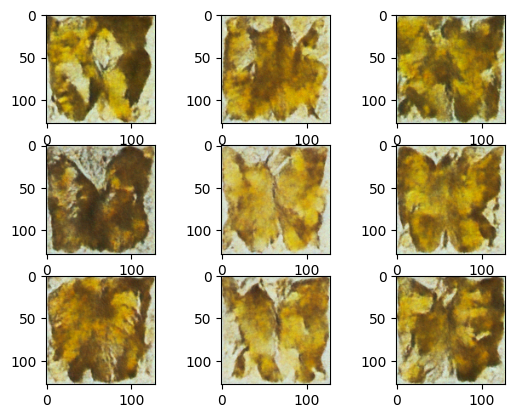

 22%|██▏       | 11/50 [14:19<1:04:14, 98.83s/it]

------------------------------


 24%|██▍       | 12/50 [15:09<53:07, 83.88s/it]  

------------------------------
Train Loss EPOCH: 12: 0.0273
Train Learning Rate EPOCH: 12: 9.771496978489323e-05
------------------------------


 26%|██▌       | 13/50 [15:59<45:20, 73.53s/it]

------------------------------
Train Loss EPOCH: 13: 0.0251
Train Learning Rate EPOCH: 13: 9.646697092574766e-05
------------------------------


 28%|██▊       | 14/50 [16:49<39:49, 66.37s/it]

------------------------------
Train Loss EPOCH: 14: 0.0248
Train Learning Rate EPOCH: 14: 9.495989344945056e-05
------------------------------


 30%|███       | 15/50 [17:38<35:47, 61.35s/it]

------------------------------
Train Loss EPOCH: 15: 0.0227
Train Learning Rate EPOCH: 15: 9.320214013201078e-05
------------------------------


 32%|███▏      | 16/50 [18:28<32:46, 57.83s/it]

------------------------------
Train Loss EPOCH: 16: 0.0226
Train Learning Rate EPOCH: 16: 9.120351140349089e-05
------------------------------


 34%|███▍      | 17/50 [19:18<30:28, 55.40s/it]

------------------------------
Train Loss EPOCH: 17: 0.0206
Train Learning Rate EPOCH: 17: 8.897515070528305e-05
------------------------------


 36%|███▌      | 18/50 [20:07<28:37, 53.68s/it]

------------------------------
Train Loss EPOCH: 18: 0.0199
Train Learning Rate EPOCH: 18: 8.652948235936705e-05
------------------------------


 38%|███▊      | 19/50 [20:57<27:07, 52.50s/it]

------------------------------
Train Loss EPOCH: 19: 0.0188
Train Learning Rate EPOCH: 19: 8.388014229596275e-05
------------------------------


 40%|████      | 20/50 [21:47<25:50, 51.67s/it]

------------------------------
Train Loss EPOCH: 20: 0.0161
Train Learning Rate EPOCH: 20: 8.104190202580812e-05
------------------------------


100%|██████████| 63/63 [00:49<00:00,  1.26it/s]

------------------------------
Train Loss EPOCH: 21: 0.0172
Train Learning Rate EPOCH: 21: 7.803058628095877e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

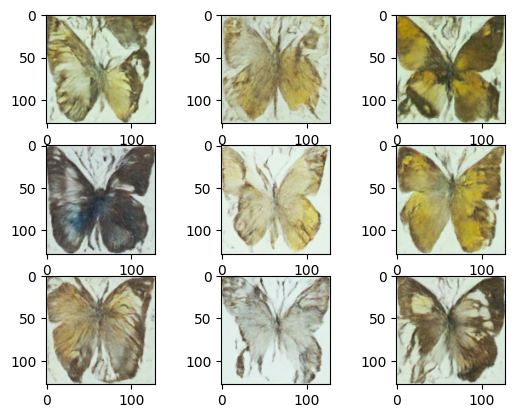

 42%|████▏     | 21/50 [25:13<47:21, 97.97s/it]

------------------------------


 44%|████▍     | 22/50 [26:02<38:57, 83.49s/it]

------------------------------
Train Loss EPOCH: 22: 0.0213
Train Learning Rate EPOCH: 22: 7.486298478330615e-05
------------------------------


 46%|████▌     | 23/50 [26:52<33:00, 73.35s/it]

------------------------------
Train Loss EPOCH: 23: 0.0196
Train Learning Rate EPOCH: 23: 7.155675863275306e-05
------------------------------


 48%|████▊     | 24/50 [27:42<28:43, 66.29s/it]

------------------------------
Train Loss EPOCH: 24: 0.0200
Train Learning Rate EPOCH: 24: 6.813034183698301e-05
------------------------------


 50%|█████     | 25/50 [28:32<25:32, 61.31s/it]

------------------------------
Train Loss EPOCH: 25: 0.0190
Train Learning Rate EPOCH: 25: 6.460283853184879e-05
------------------------------


 52%|█████▏    | 26/50 [29:22<23:08, 57.87s/it]

------------------------------
Train Loss EPOCH: 26: 0.0191
Train Learning Rate EPOCH: 26: 6.0993916465432213e-05
------------------------------


 54%|█████▍    | 27/50 [30:11<21:14, 55.43s/it]

------------------------------
Train Loss EPOCH: 27: 0.0179
Train Learning Rate EPOCH: 27: 5.732369733965931e-05
------------------------------


 56%|█████▌    | 28/50 [31:01<19:41, 53.68s/it]

------------------------------
Train Loss EPOCH: 28: 0.0172
Train Learning Rate EPOCH: 28: 5.361264462087627e-05
------------------------------


 58%|█████▊    | 29/50 [31:51<18:22, 52.49s/it]

------------------------------
Train Loss EPOCH: 29: 0.0165
Train Learning Rate EPOCH: 29: 4.9881449444902904e-05
------------------------------


 60%|██████    | 30/50 [32:40<17:13, 51.68s/it]

------------------------------
Train Loss EPOCH: 30: 0.0142
Train Learning Rate EPOCH: 30: 4.615091525270501e-05
------------------------------


100%|██████████| 63/63 [00:49<00:00,  1.27it/s]

------------------------------
Train Loss EPOCH: 31: 0.0151
Train Learning Rate EPOCH: 31: 4.244184179990459e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

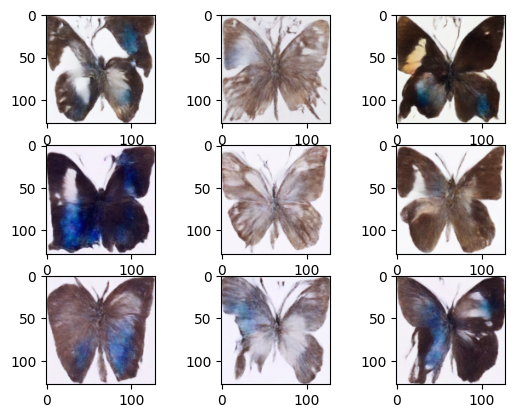

 62%|██████▏   | 31/50 [36:06<31:00, 97.91s/it]

------------------------------


 64%|██████▍   | 32/50 [36:56<25:02, 83.45s/it]

------------------------------
Train Loss EPOCH: 32: 0.0186
Train Learning Rate EPOCH: 32: 3.87749091868379e-05
------------------------------


 66%|██████▌   | 33/50 [37:46<20:46, 73.35s/it]

------------------------------
Train Loss EPOCH: 33: 0.0174
Train Learning Rate EPOCH: 33: 3.517056255575659e-05
------------------------------


 68%|██████▊   | 34/50 [38:35<17:40, 66.25s/it]

------------------------------
Train Loss EPOCH: 34: 0.0181
Train Learning Rate EPOCH: 34: 3.164889809804808e-05
------------------------------


 70%|███████   | 35/50 [39:25<15:19, 61.30s/it]

------------------------------
Train Loss EPOCH: 35: 0.0171
Train Learning Rate EPOCH: 35: 2.822955100704634e-05
------------------------------


 72%|███████▏  | 36/50 [40:15<13:29, 57.83s/it]

------------------------------
Train Loss EPOCH: 36: 0.0169
Train Learning Rate EPOCH: 36: 2.4931586001157835e-05
------------------------------


 74%|███████▍  | 37/50 [41:05<12:00, 55.40s/it]

------------------------------
Train Loss EPOCH: 37: 0.0162
Train Learning Rate EPOCH: 37: 2.1773391027694734e-05
------------------------------


 76%|███████▌  | 38/50 [41:54<10:44, 53.73s/it]

------------------------------
Train Loss EPOCH: 38: 0.0159
Train Learning Rate EPOCH: 38: 1.877257474007511e-05
------------------------------


 78%|███████▊  | 39/50 [42:44<09:37, 52.52s/it]

------------------------------
Train Loss EPOCH: 39: 0.0153
Train Learning Rate EPOCH: 39: 1.5945868320010076e-05
------------------------------


 80%|████████  | 40/50 [43:34<08:36, 51.66s/it]

------------------------------
Train Loss EPOCH: 40: 0.0132
Train Learning Rate EPOCH: 40: 1.3309032192072463e-05
------------------------------


100%|██████████| 63/63 [00:49<00:00,  1.27it/s]

------------------------------
Train Loss EPOCH: 41: 0.0140
Train Learning Rate EPOCH: 41: 1.0876768150764277e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

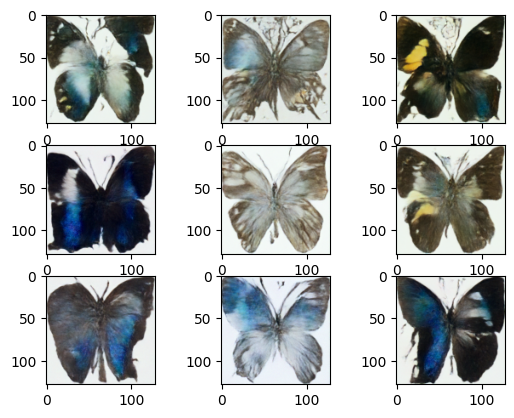

 82%|████████▏ | 41/50 [47:00<14:41, 97.92s/it]

------------------------------


 84%|████████▍ | 42/50 [47:49<11:07, 83.49s/it]

------------------------------
Train Loss EPOCH: 42: 0.0173
Train Learning Rate EPOCH: 42: 8.66263739002211e-06
------------------------------


 86%|████████▌ | 43/50 [48:39<08:33, 73.35s/it]

------------------------------
Train Loss EPOCH: 43: 0.0163
Train Learning Rate EPOCH: 43: 6.678984892190559e-06
------------------------------


 88%|████████▊ | 44/50 [49:29<06:37, 66.29s/it]

------------------------------
Train Loss EPOCH: 44: 0.0170
Train Learning Rate EPOCH: 44: 4.9368705980363415e-06
------------------------------


 90%|█████████ | 45/50 [50:19<05:06, 61.32s/it]

------------------------------
Train Loss EPOCH: 45: 0.0161
Train Learning Rate EPOCH: 45: 3.4460077415675474e-06
------------------------------


 92%|█████████▏| 46/50 [51:08<03:51, 57.85s/it]

------------------------------
Train Loss EPOCH: 46: 0.0158
Train Learning Rate EPOCH: 46: 2.214708693475065e-06
------------------------------


 94%|█████████▍| 47/50 [51:58<02:46, 55.42s/it]

------------------------------
Train Loss EPOCH: 47: 0.0155
Train Learning Rate EPOCH: 47: 1.2498386151482467e-06
------------------------------


 96%|█████████▌| 48/50 [52:48<01:47, 53.71s/it]

------------------------------
Train Loss EPOCH: 48: 0.0152
Train Learning Rate EPOCH: 48: 5.567771816690381e-07
------------------------------


 98%|█████████▊| 49/50 [53:38<00:52, 52.53s/it]

------------------------------
Train Loss EPOCH: 49: 0.0147
Train Learning Rate EPOCH: 49: 1.3938858719967363e-07
------------------------------


100%|██████████| 50/50 [54:27<00:00, 65.36s/it]

------------------------------
Train Loss EPOCH: 50: 0.0127
Train Learning Rate EPOCH: 50: 0.0
------------------------------
Training Time: 3267.91s


In [15]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_dataloader)*NUM_EPOCHS
)

accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)

start = timeit.default_timer()
for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    train_running_loss = 0
    for idx, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        clean_images = batch["images"].to(device)
        noise = torch.randn(clean_images.shape).to(device)
        last_batch_size = len(clean_images)
        
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
        
        with accelerator.accumulate(model):
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)
            
            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx+1)
    
    train_learning_rate = lr_scheduler.get_last_lr()[0]
    print("-"*30)
    print(f"Train Loss EPOCH: {epoch+1}: {train_loss:.4f}")
    print(f"Train Learning Rate EPOCH: {epoch+1}: {train_learning_rate}")
    if epoch%10 == 0:
        sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)
    print("-"*30)
    
stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

  0%|          | 0/1000 [00:00<?, ?it/s]

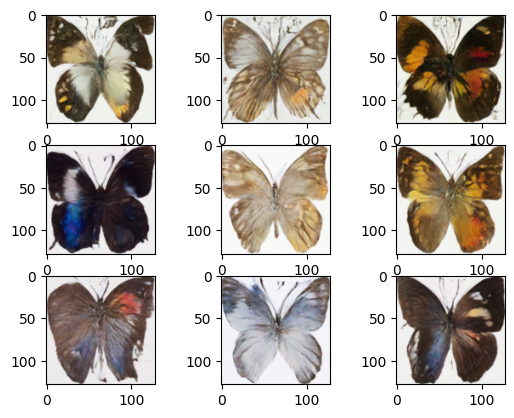

In [16]:
sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)